# Forecasting examples


In [ ]:
%load_ext autoreload
%autoreload 2

In [9]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from foressment_ai.forecasting.forecaster_ai.loader import DataLoaderAndPreprocessorDefault
from foressment_ai.forecasting.forecaster_ai.forecaster import *

### Download and prepare the dataset.

In [12]:
dataset = DataLoaderAndPreprocessorDefault()
dataset.load_data('swat', label_format='binary')
dataset.set_train_size(0.8)

dataset.shape

(495000, 46)

In [13]:
pd.DataFrame(dataset.data, columns=dataset.feature_names).head(5)

,FIT101,LIT101,MV101,P101,P102,AIT202,FIT201,MV201,P201,P202,...,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
0,0.0,124.3135,1.0,1.0,1.0,8.313446,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0
1,0.0,124.3920,1.0,1.0,1.0,8.313446,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0
2,0.0,124.4705,1.0,1.0,1.0,8.313446,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0
3,0.0,124.6668,1.0,1.0,1.0,8.313446,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0
4,0.0,124.5098,1.0,1.0,1.0,8.313446,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0


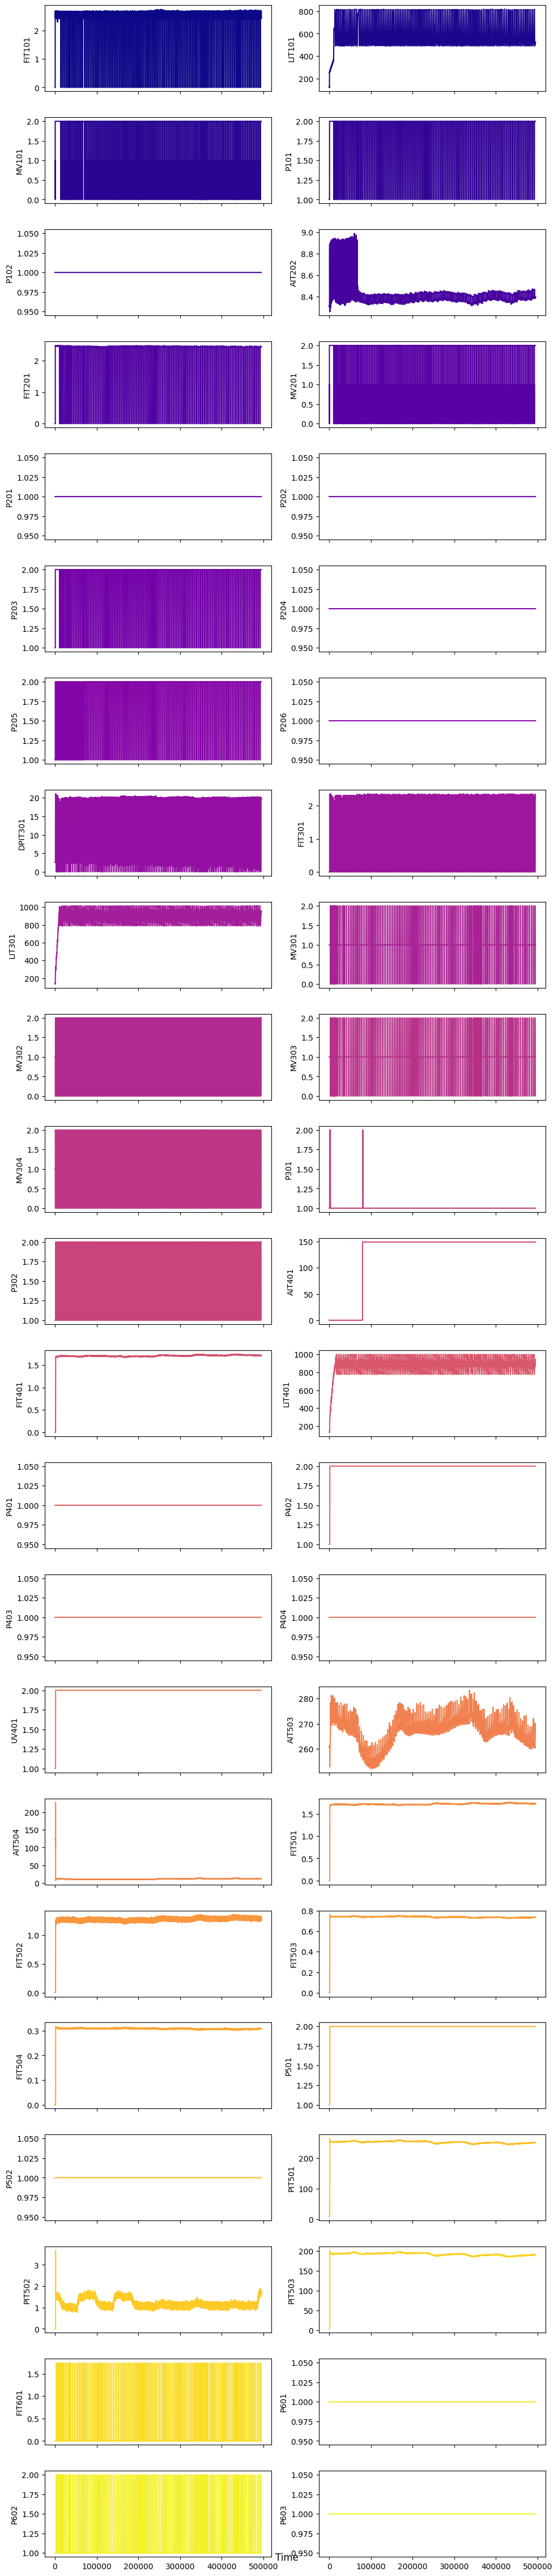

In [25]:
dataset.draw(size=dataset.shape[0])

Get train sample.

In [16]:
train = dataset.get_train_data()
test = dataset.get_test_data()

print('Train data:', train.shape)
print('Test data:', test.shape)

Train data: (396000, 46)
Test data: (99000, 46)


In [ ]:
del dataset

Normalization

In [17]:
train.scale()
test.scale(scaler=train.scaler)

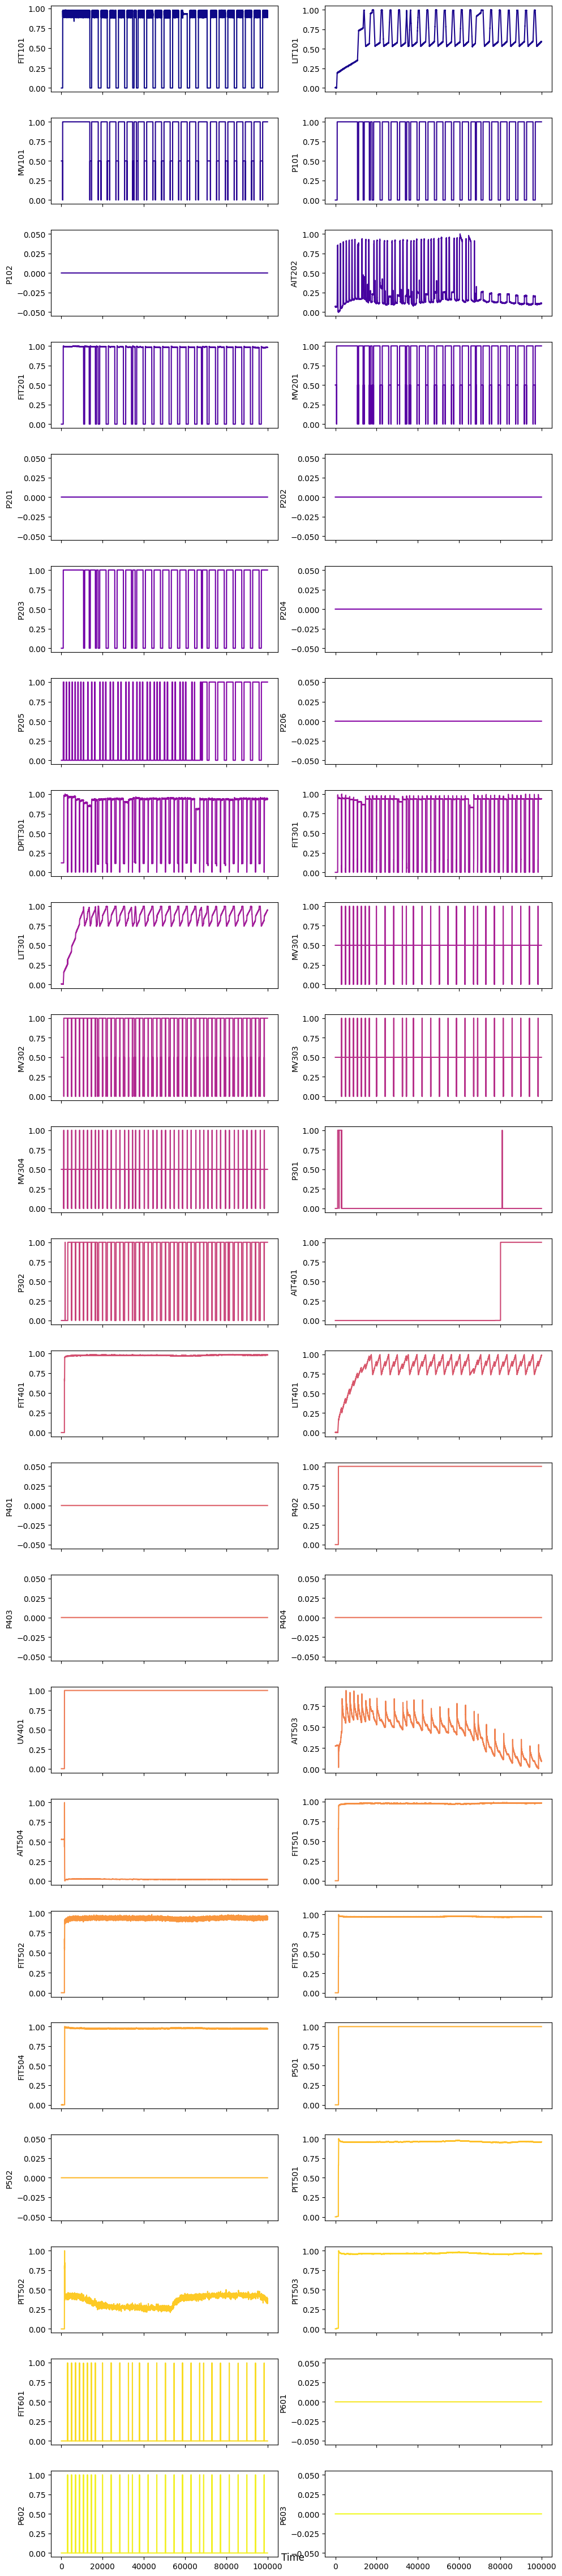

In [18]:
train.draw(size=100000)

Create time series generators.

In [19]:
look_back_length = 90
horizon = 1
n_features = train.shape[1]

model_params = AIForecasterParameters(n_features=n_features,
                                      look_back_length=look_back_length,
                                      horizon=horizon)

ts_train = TSGenerator(train.data, model_params)
#Data shape = (n_time_window, look_back_length, n_features)
print('Train timeseries data:', ts_train.data.shape)
#Train target shape = (n_time_window, horizon, n_features)
print('Train timeseries targets:', ts_train.targets.shape)

forecasting_data_length = 1
ts_test = TSGenerator(test.data, model_params)

print('Test timeseries data:', ts_test.data.shape)
#Test target shape = (n_time_window, forecasting_data_length, n_features)
print('Test timeseries targets:', ts_test.targets.shape)

Train timeseries data: (395910, 90, 46)
Train timeseries targets: (395910, 1, 46)
Test timeseries data: (98910, 90, 46)
Test timeseries targets: (98910, 1, 46)


In [ ]:
del train

### Keras Tuner

In [20]:
tuner = AIForecasterTuner(model_params)

Determine the value of hyperparameters for tuning.

In [22]:
tuned_hps = {
             'block_type': ['SimpleRNN', 'LSTM', 'GRU'],
             'n_rec_layers': [2, 3, 4],
             'units': [[512, 256], [256, 128], [128, 64], [64, 32]],
             'dropout': [0.0, 0.01, 0.1],
             'hidden_activation': ['tanh', 'relu'],
             'output_activation': ['linear', 'sigmoid']
            }
tuner.set_tuned_hps(block_type=tuned_hps['block_type'],
                    units=tuned_hps['units'],
                    n_rec_layers=tuned_hps['n_rec_layers'],
                    dropout=tuned_hps['dropout'],
                    hidden_activation=tuned_hps['hidden_activation'],
                    output_activation=tuned_hps['output_activation'])
print(tuner.hp_choices)

{'block_type': ['SimpleRNN', 'LSTM', 'GRU'], 'units': {'units_0': [512, 256], 'units_1': [256, 128], 'units_2': [128, 64], 'units_3': [64, 32]}, 'dropout': [0.0, 0.01, 0.1], 'n_rec_layers': [2, 3, 4], 'hidden_activation': ['tanh', 'relu'], 'output_activation': ['linear', 'sigmoid']}


Run the hyperparameter search. Find the optimal hyperparameters and model.

In [28]:
batch_size = 128

In [26]:
x = ts_train.get_data(sample=(-200000, None))
y = ts_train.get_targets(sample=(-200000, None))
x.shape, y.shape

((200000, 90, 46), (200000, 1, 46))

In [29]:
bests = tuner.find_best_models(x=x, y=y,
                       tuner_type='BayesianOptimization',
                       max_trials=10,
                       epochs=5,
                       n_models=5,
                       batch_size=batch_size)

Trial 10 Complete [02h 08m 05s]
loss: 0.00021117740834597498

Best loss So Far: 0.00021117740834597498
Total elapsed time: 11h 40m 41s
Results summary
Showing 5 best trials

Trial 09 summary
Hyperparameters:
n_rec_layers: 3
block_type: GRU
units_0: 512
hidden_activation: tanh
dropout: 0.0
units_1: 256
output_activation: sigmoid
units_2: 64
Score: 0.00021117740834597498

Trial 01 summary
Hyperparameters:
n_rec_layers: 4
block_type: GRU
units_0: 256
hidden_activation: tanh
dropout: 0.01
units_1: 128
output_activation: linear
units_2: 128
units_3: 64
Score: 0.0002780616341624409

Trial 00 summary
Hyperparameters:
n_rec_layers: 4
block_type: GRU
units_0: 256
hidden_activation: relu
dropout: 0.0
units_1: 128
output_activation: sigmoid
units_2: 128
units_3: 64
Score: 0.00028112437576055527

Trial 08 summary
Hyperparameters:
n_rec_layers: 3
block_type: LSTM
units_0: 256
hidden_activation: tanh
dropout: 0.0
units_1: 256
output_activation: sigmoid
units_2: 128
Score: 0.0005318693001754582

Tria

Save deep forecasting model configurations.

In [30]:
for i, model in enumerate(bests):
    filename = 'ai_models/configs/swat_' + model.default_filename + f'_{i}.json'
    model.save_model_config(filename)
    print(f'Model {i} configuration save to', filename)

Model 0 configuration save to ai_models/configs/swat_gru_512_256_64_d0_0.json
Model 1 configuration save to ai_models/configs/swat_gru_256_128_128_64_d01_1.json
Model 2 configuration save to ai_models/configs/swat_gru_256_128_128_64_d0_2.json
Model 3 configuration save to ai_models/configs/swat_lstm_256_256_128_d0_3.json
Model 4 configuration save to ai_models/configs/swat_gru_512_128_128_d1_4.json


In [ ]:
# bests = [AIForecaster(from_config='ai_models/configs/swat_gru_256_80_32_d0_0.json'),
#          AIForecaster(from_config='ai_models/configs/swat_gru_256_80_d01_1.json'),
#          AIForecaster(from_config='ai_models/configs/swat_lstm_128_d01_2.json'),
#          AIForecaster(from_config='ai_models/configs/swat_gru_180_80_32_d0_3.json'),
#          AIForecaster(from_config='ai_models/configs/swat_simplernn_180_d0_4.json'),]

Train model.

In [31]:
for i, model in enumerate(bests):
    print(model.model.summary())
    model.train(X=ts_train.get_data(),
                y=ts_train.get_targets(),
    batch_size=batch_size, n_epochs=5, validation_split=0.1)

    # for j in range(len(model.model.weights)):
    #     model.model.weights[j]._handle_name = model.model.weights[j].name + str(j) + str(i)

    filename = 'ai_models/ready/swat_'+ model.default_filename + f'_{i}.keras'
    model.save_model(filename)
    print('Model save to', filename)
    print('')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 90, 512)           860160    
                                                                 
 dropout (Dropout)           (None, 90, 512)           0         
                                                                 
 gru_1 (GRU)                 (None, 90, 256)           591360    
                                                                 
 dropout_1 (Dropout)         (None, 90, 256)           0         
                                                                 
 gru_2 (GRU)                 (None, 64)                61824     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 46)                2

### Evaluation

Load

In [ ]:
bests = [AIForecaster(from_file='ai_models/ready/swat_gru_256_80_32_d0_0.keras'),
         AIForecaster(from_file='ai_models/ready/swat_gru_256_80_d01_1.keras'),
         AIForecaster(from_file='ai_models/ready/swat_lstm_128_d01_2.keras'),
         AIForecaster(from_file='ai_models/ready/swat_gru_180_80_32_d0_3.keras'),
         AIForecaster(from_file='ai_models/ready/swat_simplernn_180_d0_4.keras')]

print(bests)

##### Forecasting data length is eqaual to horizon

In [32]:
print('Forecasting data length:', forecasting_data_length)

current_batch = ts_test.get_data()
print('Data for forecasting:', current_batch.shape)

Forecasting data length: 1
Data for forecasting: (98910, 90, 46)


In [33]:
estimator = ForecastEstimator(feature_names=test.feature_names)
estimator.set_true_values(ts_test.get_targets())
estimator.set_first_batch(ts_test.get_data(window_id=0))

In [34]:
nm = NaiveForecaster(model_params)
naive_pred = nm.forecasting(current_batch, forecasting_data_length=forecasting_data_length)
estimator.set_pred_values(naive_pred, model_name='naive')

Forecasting: 100%|██████████| 98910/98910 [06:02<00:00, 272.74it/s] 


In [35]:
for i, model in enumerate(bests):
    print(model.default_filename)
    pred = model.forecasting(current_batch,
           forecasting_data_length=forecasting_data_length)
    estimator.set_pred_values(pred, model_name=model.default_filename)

gru_512_256_64_d0
773/773 [==============================] - 204s 262ms/step
gru_256_128_128_64_d01
773/773 [==============================] - 179s 230ms/step
gru_256_128_128_64_d0
773/773 [==============================] - 154s 199ms/step
lstm_256_256_128_d0
773/773 [==============================] - 182s 235ms/step
gru_512_128_128_d1
773/773 [==============================] - 181s 234ms/step


In [36]:
estimator.save_pred_result(dataset_name='swat')

Save forecaster_results/swat_naive.npy
Save forecaster_results/swat_gru_512_256_64_d0.npy
Save forecaster_results/swat_gru_256_128_128_64_d01.npy
Save forecaster_results/swat_gru_256_128_128_64_d0.npy
Save forecaster_results/swat_lstm_256_256_128_d0.npy
Save forecaster_results/swat_gru_512_128_128_d1.npy


In [37]:
estimator.estimate()
estimator.quality

,naive_MSE,naive_RMSE,naive_MAE,gru_512_256_64_d0_MSE,gru_512_256_64_d0_RMSE,gru_512_256_64_d0_MAE,gru_256_128_128_64_d01_MSE,gru_256_128_128_64_d01_RMSE,gru_256_128_128_64_d01_MAE,gru_256_128_128_64_d0_MSE,gru_256_128_128_64_d0_RMSE,gru_256_128_128_64_d0_MAE,lstm_256_256_128_d0_MSE,lstm_256_256_128_d0_RMSE,lstm_256_256_128_d0_MAE,gru_512_128_128_d1_MSE,gru_512_128_128_d1_RMSE,gru_512_128_128_d1_MAE
FIT101,3.860776e-02,0.196489,0.074277,4.435661e-03,0.066601,0.051374,0.015469,0.124375,0.100988,5.217759e-02,0.228424,0.129972,1.700792e-01,0.412407,0.370051,6.436542e-03,0.080228,0.069054
LIT101,1.117353e-03,0.033427,0.020443,7.497618e-03,0.086589,0.071356,0.006425,0.080157,0.052620,6.781880e-03,0.082352,0.062410,2.635061e-02,0.162329,0.146951,6.222222e-03,0.078881,0.055559
MV101,1.508695e-02,0.122829,0.026110,3.791961e-03,0.061579,0.029855,0.005250,0.072455,0.041750,2.281375e-02,0.151042,0.068578,5.234002e-02,0.228779,0.203312,3.609779e-03,0.060081,0.042414
P101,4.319078e-02,0.207824,0.043191,1.813261e-03,0.042582,0.007252,0.004340,0.065878,0.049664,7.083057e-04,0.026614,0.004955,1.836118e-01,0.428499,0.372023,1.289034e-03,0.035903,0.012080
P102,0.000000e+00,0.000000,0.000000,1.871288e-07,0.000433,0.000267,0.000062,0.007850,0.006627,1.450075e-07,0.000381,0.000257,4.560050e-08,0.000214,0.000214,7.536228e-06,0.002745,0.001712
AIT202,3.563566e-04,0.018877,0.007114,2.879677e-03,0.053663,0.050259,0.002688,0.051848,0.037982,2.275118e-03,0.047698,0.043831,3.451627e-03,0.058751,0.042084,2.104295e-03,0.045873,0.041829
FIT201,4.057651e-02,0.201436,0.043279,1.334376e-03,0.036529,0.014872,0.003831,0.061899,0.047857,1.259207e-03,0.035485,0.016361,1.757614e-01,0.419239,0.363732,1.233039e-03,0.035115,0.012343
MV201,1.430593e-02,0.119607,0.025104,1.112054e-03,0.033347,0.008681,0.003009,0.054850,0.033280,1.556767e-03,0.039456,0.010124,4.804980e-02,0.219203,0.188516,1.262262e-03,0.035528,0.012355
P201,0.000000e+00,0.000000,0.000000,1.590746e-07,0.000399,0.000228,0.000240,0.015507,0.014556,2.549747e-08,0.000160,0.000100,4.919604e-08,0.000222,0.000222,2.899935e-06,0.001703,0.001132
P202,0.000000e+00,0.000000,0.000000,4.864982e-08,0.000221,0.000168,0.000019,0.004319,0.002894,5.322225e-07,0.000730,0.000303,9.435276e-08,0.000307,0.000307,4.446384e-06,0.002109,0.001399


In [46]:
estimator.quality = estimator.quality.round(5)
estimator.save_quality('swat_quality')

In [ ]:
estimator.draw(feature_names=['FIT101', 'LIT101'], size=100)

##### By processes

In [38]:
process_feature_names = {}
for i in range(1, 7):
    features = [feature for feature in test.feature_names if feature[-3]==str(i)]
    process_feature_names[f'P{i}'] = features
    print(f'P{i}:', features)

P1: ['FIT101', 'LIT101', 'MV101', 'P101', 'P102']
P2: ['AIT202', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206']
P3: ['DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302']
P4: ['AIT401', 'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401']
P5: ['AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501', 'PIT502', 'PIT503']
P6: ['FIT601', 'P601', 'P602', 'P603']


In [39]:
proc_results = pd.DataFrame()

for i in range(1, 7):
    estimator_p = ForecastEstimator(feature_names=process_feature_names[f'P{i}'])
    
    feature_idx = [j for j, feature in enumerate(test.feature_names) if feature in process_feature_names[f'P{i}']]
    targets = ts_test.get_targets()[:, :, feature_idx]
    
    estimator_p.set_true_values(targets)
    estimator_p.set_pred_values(naive_pred[:, :, feature_idx], model_name='naive')
    
    for model_name, pred_val in estimator.pred.items():
        pred_val = pred_val[:, :, feature_idx]
        estimator_p.set_pred_values(pred_val, model_name=model_name)
    
    estimator_p.estimate()
    for c in estimator_p.quality.columns:
        proc_results.loc[f'P{i}', c] = estimator_p.quality.loc['ALL_FEATURES', c]

In [40]:
proc_results

,naive_MSE,naive_RMSE,naive_MAE,gru_512_256_64_d0_MSE,gru_512_256_64_d0_RMSE,gru_512_256_64_d0_MAE,gru_256_128_128_64_d01_MSE,gru_256_128_128_64_d01_RMSE,gru_256_128_128_64_d01_MAE,gru_256_128_128_64_d0_MSE,gru_256_128_128_64_d0_RMSE,gru_256_128_128_64_d0_MAE,lstm_256_256_128_d0_MSE,lstm_256_256_128_d0_RMSE,lstm_256_256_128_d0_MAE,gru_512_128_128_d1_MSE,gru_512_128_128_d1_RMSE,gru_512_128_128_d1_MAE
P1,0.019601,0.019601,0.032804,0.003508,0.003508,0.032021,0.006309,0.006309,0.050330,0.016496,0.016496,0.053235,0.086476,0.086476,0.218510,0.003513,0.003513,0.036164
P2,0.015736,0.015736,0.017986,0.000631,0.000631,0.010295,0.001592,0.001592,0.025324,0.000625,0.000625,0.009673,0.066264,0.066264,0.149390,0.000717,0.000717,0.012343
P3,0.030406,0.030406,0.041529,0.004152,0.004152,0.031333,0.005972,0.005972,0.044752,0.004605,0.004605,0.030848,0.047427,0.047427,0.117767,0.003284,0.003284,0.028277
P4,0.000032,0.000032,0.001744,0.000457,0.000457,0.008800,0.001415,0.001415,0.019957,0.000540,0.000540,0.010004,0.000612,0.000612,0.008940,0.000546,0.000546,0.013172
P5,0.000221,0.000221,0.004165,0.004147,0.004147,0.026186,0.004945,0.004945,0.029526,0.002955,0.002955,0.021944,0.003368,0.003368,0.021044,0.002947,0.002947,0.026393
P6,0.007472,0.007472,0.007902,0.000583,0.000583,0.002184,0.001367,0.001367,0.019455,0.003679,0.003679,0.004387,0.003706,0.003706,0.008620,0.001858,0.001858,0.013873


In [47]:
proc_results = proc_results.round(5)
proc_results.to_csv('forecaster_results/swat_procs_quality.csv')